Подключаемые библиотеки:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from typing import Callable

Исходные данные:

In [4]:
C = -30
N = 9
K = 83

a = np.pi * (N + 10)
b = a + K / 50 + 2

h = 0.1
n = int((b - a) / h)
h = (b - a) / (n)

Используемые функции вычисления интегралов:

In [5]:
def quad(f: Callable[[float], float], a: float, b: float, h: float) -> float:
    return integrate.quad(f, a, b)[0]


def simp(f: Callable[[float], float], a: float, b: float, h: float) -> float:
    n = int((b - a) / h)
    h = (b - a) / n
    sum = 0
    subf = lambda a,b: (b-a)/6.0 * (f(a) + 4*f((a+b)/2) + f(b))
    for i in range(0, n):
        xi = a + i * h
        xn = xi + h
        sum += subf(xi, xn)
    return sum

Метод решения СЛАУ из ЛР1:

In [6]:
def SeidelMethod(mtr: np.ndarray[float], vct: np.ndarray[float], x0: np.ndarray[float], eps = 1e-10):
    n = len(mtr)
    xp = x0.copy()
    converge = False

    while not converge:
        x = xp.copy()
        for i in range(n):
            s1 = 0
            s2 = 0
            if (i > 0):         s1 = mtr[i][i - 1] * x[i - 1]
            elif (i < n - 1):   s2 = mtr[i][i + 1] * xp[i + 1]

            x[i] = (vct[i] - s1 - s2) / mtr[i][i]
        xp = x
        converge = np.linalg.norm(x - xp) <= eps
    return x

Используемые финитные функции $\varphi(x)$:

In [7]:
def getPhiIndexed(x: np.ndarray, h: np.float64, i: int)->Callable[[np.float64], np.float64]:
    hnr: np.float64 = h*np.sqrt(h)
    if i == 0:          return lambda t: (x[1] - t) / hnr if t <= x[1] else 0.0
    if i == x.size - 1: return lambda t: (t - x[-2]) / hnr if t >= x[-2] else 0.0
    else:
        def phi(t):
            if t >= x[i-1] and t <= x[i]:   return (t - x[i-1]) / hnr
            elif t >= x[i] and t <= x[i+1]: return (x[i+1] - t) / hnr
            else:                           return 0.0
        return phi

Параметры p,q определяются по формулам:
$$
p(x)=\sin(Nx/\pi)+\cos(2N)x+C
$$
$$
q(x)=e^{\cos(Nx/\pi)}+\cos^2(Nx/10)+1
$$



In [8]:
def p(x: float):
    return np.sin((N * x) / np.pi) + x * np.cos(2 * N) + C

def dp(x: float):
    return np.cos(N * x / np.pi) * N / np.pi + np.cos(2 * N)

def q(x: float):
    return np.exp(np.cos(N * x / np.pi)) + np.pow(np.cos(N * x / 10), 2) + 1

Нетривиальный физически осмысленный пример:
$$
u(x)=\sin^2\left(\pi\frac{x-b}{b-a}\right)
$$
$$
\frac{du}{dx}=\frac{\pi\sin\left(\frac{2\pi(x-b)}{b-a}\right)}{b-a}
$$
$$
\frac{d^2u}{dx^2}=\frac{2\pi^2\cos\left(\frac{2\pi(x-b)}{b-a}\right)}{(b-a)^2}
$$
Тогда функция в правой части будет:
$$
f(x)=-\frac{dp}{dx}\frac{du}{dx}-p\frac{d^2u}{dx^2}+qu
$$

In [9]:
def u(x: float):
    return np.pow(np.sin(np.pi * (x - b) / (b - a)), 2)

def du(x: float):
    return np.pi * np.sin(2 * np.pi * (x - b) / (b - a)) / (b - a)

def ddu(x: float):
    return 2 * np.pow(np.pi, 2) * np.cos(2 * np.pi * (x - b) / (b - a)) / np.pow(b - a, 2)

def f(x: float):
    return -dp(x) * du(x) - p(x) * ddu(x) + q(x) * u(x)

Функция, генерирующая матрицу системы МКЭ и вектор в правой части: 

In [10]:
def createMatrVect(n: np.float64, ifunc = quad) -> tuple[np.ndarray, np.ndarray]:
        x, h = np.linspace(a, b, n, retstep=True)
        h3 = 1.0 / np.pow(h, 3)
        
        mtr = np.zeros((n-2, n-2))
        vct = np.zeros(n-2)
        hn = 1.0/np.sqrt(h)

        md = np.zeros(n-2)
        ad = np.zeros(n-2)
        bd = np.zeros(n-2)

        for i in range(n-2):
            md[i] = ifunc(lambda t: h3 * p(t) + q(t) * np.pow(getPhiIndexed(x, h, i+1)(t), 2), x[i], x[i+2], h/10)
            vct[i] = hn * ifunc(lambda t: f(t) * getPhiIndexed(x, h, i+1)(t), x[i], x[i+2], h/10)

            bd[i] = ifunc(lambda t: q(t) * getPhiIndexed(x, h, i)(t) * getPhiIndexed(x, h, i+1)(t) - h3 * p(t), x[i], x[i+1], h/10)
            ad[i] = ifunc(lambda t: q(t) * getPhiIndexed(x, h, i+1)(t) * getPhiIndexed(x, h, i+2)(t) - h3 * p(t), x[i+1], x[i+2], h/10)
            
        np.fill_diagonal(mtr, md)
        np.fill_diagonal(mtr[:, 1:], ad[:-1])
        np.fill_diagonal(mtr[1:, :], bd[1:])

        return mtr, vct

Функция выполнения лабораторной работы:

In [ ]:
def lab2(type: str, ifunc = Callable[[float], float]):

    global n, h
    fig, (axtst, axrh) = plt.subplots(2, 1, figsize=(10, 8))
    fig.suptitle(f'Решение методом {type}')
    axtst.set_title('Функция u(x)')
    axrh.set_title(f'Погрешность r(h)')

    xv = np.linspace(a, b, n) 
    uv = u(xv)

    matr, vect = createMatrVect(n, ifunc)
    uh = [u(a)] + list(np.linalg.solve(matr, vect)) + [u(b)]
    r = np.sqrt(h) * np.linalg.norm(uv - uh)
    print(f'r(h={h}) = {r}')

    axtst.plot(xv, uv, color='red', label='u(x)')
    axtst.plot(xv, uh, color='blue', label=f'u(h={h})')
    axtst.grid()
    axtst.legend()

    t = 100
    hv = np.zeros(t)
    rv = np.zeros(t)
    for i in range(t):
        h = 1 / (10 * (i + 1))
        n = int((b - a) / h)

        xv = np.linspace(a, b, n)
        uv = u(xv)

        matr, vect = createMatrVect(n, ifunc)
        uh = [u(a)] + list(SeidelMethod(matr, vect, vect)) + [u(b)]

        r = np.sqrt(h) * np.linalg.norm(uv - uh)
        hv[i] = h
        rv[i] = r

        print(f'[{type}]: Computing... [{i}/{t}], n={n}')

    axrh.plot(hv, rv, color='red')
    axrh.set_yscale('log')

    print(f'h[0] = {hv[0]}\nh[1] = {hv[1]}')
    print(f'r[0] = {rv[0]}\nr[1] = {rv[1]}')
    print(f'p = {np.sqrt(rv[1]/rv[0])}')

Проверка работоспособности метода и оценка погрешности:



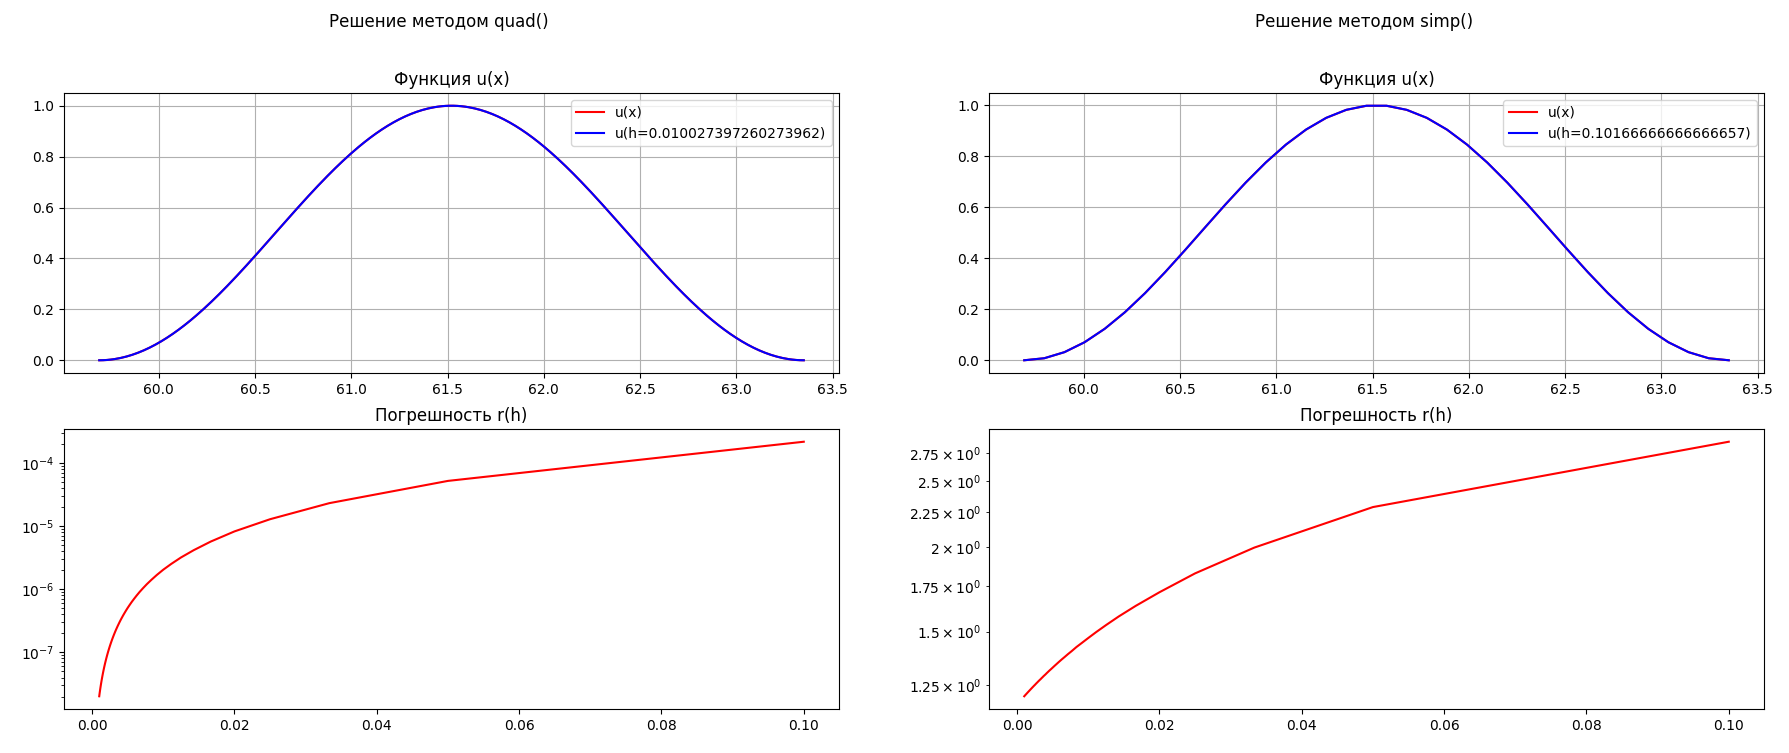

Запуск программы выполнения ЛР:

In [ ]:
if __name__ == '__main__':
    lab2("quad()", quad)
    lab2("simp()", simp)

    plt.show()